**TODO**: remove this markdown after all of the other TODOs have been completed.

Control-f for all "TODO"'s in the notebook.

# **Predicting S&P 500 Prices from NYT and WSJ Headlines**

**Authors**: James Strong, Elizabeth Zhong, Matthew Allana, William Ma, Rohil Daliwal

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Table Of Contents**
1. Problem Statement
2. Our Approach
3. Headline Data Cleaning and Processing: Sentiment Analysis
4. Start the notebook at this block!
5. Data Exploration and Visualization
    - NYT and WSJ Headlines
    - S&P500 Data
    - Combine Headlines and S&P500 Data
6. Baseline Model: Majority Class
7. Final Models: 
    - Random Forest
    - AdaBoosting
8. Model Interpretation and Results

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Problem Statement**

#### **Context**

Financial markets are highly sensitive to news and public sentiment, making accurate market predictions a challenging yet essential task for investors, analysts, and policymakers. Traditional methods of predicting stock market trends often rely on historical price data, technical indicators, and economic metrics, but they may overlook the impact of real-time news sentiment on market dynamics. This project aims to address this gap by leveraging the sentiment of headlines from the New York Times (NYT) and Wall Street Journal (WSJ) as a proxy for public and market sentiment. By analyzing how the tone and context of headlines correlate with movements in the S&P 500 index, we seek to uncover patterns that can complement existing predictive models. This approach reflects the growing importance of sentiment analysis in financial forecasting, recognizing the critical role that media and public perception play in shaping market behavior.

#### **Motivation**

The motivation for building a model to predict S&P 500 closing prices using the sentiments of New York Times (NYT) and Wall Street Journal (WSJ) headlines lies in the significant influence that public sentiment and news have on financial markets. Headlines often capture prevailing market sentiment, economic developments, and geopolitical events, which can drive investor behavior and, consequently, market movements. By analyzing the sentiment expressed in NYT headlines, we aim to extract valuable insights into market sentiment that could enhance traditional financial models. Integrating sentiment analysis with market prediction can improve the timeliness and accuracy of forecasts, providing a more comprehensive tool for investors and analysts to make informed decisions in a rapidly changing economic environment.

#### **Problem Statement** 

Using various sentiment analysis methods (VADER, TextBlob, BERT), we aim to compute sentiment scores for NYT headlines and WSJ headline between 1998 and 2020. Each headline includes a date and section field as well. NYT headlines were collected from 1990 to 2020 (avoiding harder to predict post-COVID fluctuations in the market). WSJ headlines were collected from 1998 to 2021. For this reason, we will use the years in overlap to perform sentiment analysis (1998 - 2020). Subsequent S&P 500 data closing prices have been collected at each time period during this timeframe, and we scaled these values to account for inflation.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Our Approach**

We created a dataframe with an entry for each time point. For that time point, we average the sentiment scores for that day, and also add the number of headlines from each section into the row. Finally, our response is the S&P 500 closing price.

For the sentiment analysis, we used three different methods - VADER and TextBlob and BERT - to give a score to each NYT and WSJ article headline. Due to the short nature of each headline (on average 6 words or less), the majority of scores are 0, thus we exclude sentiment scores of 0 in order to assess either a positive or negative value for the time period - we will experiment with this threshold. It should be noted that there are many more headlines for the WSJ compared to the NYT, so we could only perform BERT on the WSJ enteries due to the computational time to incorporate this model. After testing multiple time points in milestones 4, we concluded that the average sentiment analysis for each month worked best to predict the S&P 500. This means we have a df where each row is a day date (averaged sentiment scores for that day and S&P closing price for that day), week (averaged sentiment scores for that day and averaged S&P closing price for that week) and so on.

#### **Datasets** 

For our **headline sentiment analysis**, we sourced two datasets -- New York Times headlines and Wall Street Journal headlines. These datasets are both cited from Kaggle.

1. Kaggle Wall Street Journal: https://www.kaggle.com/datasets/amogh7joshi/wsj-headline-classification/data

    The dataset consists of over 19,000 headlines scraped from the Wall Street Journal archives, spanning the period from May 3, 1998, to June 30, 2021. The headlines are organized into 67 categories based on the Wall Street Journal's classification system, making the dataset a valuable resource for tasks such as news category classification and unsupervised clustering. Headlines were randomly sampled (3-4 per day) and categorized, with categories containing fewer than 100 entries removed.

2. Kaggle New York Times: https://www.kaggle.com/datasets/johnbandy/new-york-times-headlines

    This dataset contains headlines from articles published by The New York Times between 1990 and 2020, along with accompanying metadata such as author, URL, word count, section, and more. It was created in July 2021 using The New York Times Article Search API. While it provides a comprehensive archive for text analysis and research, some records may have incomplete data due to API limitations.

For our **S&P closing prices**, we are using Python’s built-in Yahoo Finance function (yfinance) to pull historical stock market data and storing it in a dataframe.

#### **Dependencies**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

import yfinance as yf

import torch
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from wordcloud import WordCloud

import warnings

`sklearn`: For model training, evaluation, and optimization.

`yfinance`: Fetches historical financial market data, which we used to extract stock prices and related financial information for analysis.

`textblob`: For TextBlob sentiment analysis and extracting sentiment scores from headline text.

`vaderSentiment`: For lexicon-based sentiment analysis, particularly designed for short text like news headlines and extracting sentiment scores from headline text.

`transformers`: Provides tools for transformer models like BERT. We specifically used `AutoTokenizer` and `AutoModelForSequenceClassification` for implementing pre-trained BERT models to perform sentiment analysis.

`imbalanced-learn`: We used `SMOTE` (Synthetic Minority Oversampling Technique) for handling imbalanced datasets, which ensures balanced training datasets for better model performance.

`tqdm`: Displays progress bars for loops and iterations that allow us to see progress updates during particularly long sentiment analysis trials.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Headline Data Cleaning and Processing: Sentiment Analysis**

#### **Cleaning Headline Datasets**

First, we load and process the NYT and WSJ headline datasets. Since we plan to implement sentiment analysis on just the headline text and investigate these sentiments over time, the columns of interest are the publishing dates and the headline text. Note that the NYT headline dataset is more rich (including authors, word count, and more), however, we will limit the scope to just the headline text.

In [ ]:
# load NYT and WSJ headline datasets
archive_path = "archive"
dfs = []
for filename in os.listdir(archive_path):
    if filename.endswith(".csv") and filename.startswith("new_york_times_stories_"):
        file_path = os.path.join(archive_path, filename)
        
        df = pd.read_csv(file_path, dtype={"print_page": str})
        dfs.append(df)

data_nyt= pd.concat(dfs, ignore_index=True)
data_wsj = pd.read_csv("./archive/wsj_headlines.csv")

Let's take a peek at these dataframes!

In [ ]:
# NYT Headlines
display(data_nyt.head())

In [ ]:
# WSJ Headlines
display(data_wsj.head())

For consistency, we will rename the columns of both CSVs and align the start date to be July 1998 - January 2020.

In [ ]:
# NYT headline data
df_nyt = data_nyt[["headline", "pub_date", "source"]].copy()
df_nyt = df_nyt[(df_nyt['pub_date'] >= '1998-07-01') & (df_nyt['pub_date'] < '2020-01-01')]
df_nyt.rename(columns={'pub_date': 'date'}, inplace=True)
df_nyt['date'] = pd.to_datetime(df_nyt['date'], errors='coerce', utc=True)
df_nyt["source"] = "nyt"

In [ ]:
# WSJ headline data
df_wsj = data_wsj[["Date", "Headline"]].copy()
df_wsj['Date'] = pd.to_datetime(df_wsj['Date'], errors='coerce', utc=True)
df_wsj = df_wsj[(df_wsj['Date'] >= '1998-07-01') & (df_wsj['Date'] < '2020-01-01')]
df_wsj.rename(columns={'Date': 'date', 'Headline': 'headline'}, inplace=True)
df_wsj["source"] = "wsj"

In [ ]:
display(df_nyt.head())
display(df_wsj.head())

Now, we check for missingess to ensure our datset is complete.

In [ ]:
# Check for missingness
print("NYT Headline Missingness Summary")
display(df_nyt.isnull().sum())

print("WSJ Headline Missingness Summary")
display(df_wsj.isnull().sum())

In [ ]:
df_nyt = df_nyt.dropna(subset=["headline"])
display(df_nyt.isnull().sum())

**Headline Distribution Visualization**

To better visualize the headline distribution over time, let's plot the annual headline count for both the Wall Street Journal and New York Times headlines datasets.

In [ ]:
df_wsj['year'] = df_wsj['date'].dt.year
df_nyt['year'] = df_nyt['date'].dt.year

# Filter and count headlines for WSJ and NYT by year
wsj_headlines_per_year = df_wsj[df_wsj['source'].str.lower() == 'wsj'].groupby('year')['headline'].count()
nyt_headlines_per_year = df_nyt[df_nyt['source'].str.lower() == 'nyt'].groupby('year')['headline'].count()

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# WSJ Headlines Plot
axs[0].bar(wsj_headlines_per_year.index, wsj_headlines_per_year.values, color='orange', label='WSJ')
axs[0].set_title('WSJ Headlines Per Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Headlines')
axs[0].grid(axis='y', linestyle='--', alpha=0.5)
axs[0].legend()

# NYT Headlines Plot
axs[1].bar(nyt_headlines_per_year.index, nyt_headlines_per_year.values, color='blue', label='NYT')
axs[1].set_title('NYT Headlines Per Year')
axs[1].set_xlabel('Year')
axs[1].grid(axis='y', linestyle='--', alpha=0.5)
axs[1].legend()
plt.tight_layout()
plt.show()

**Notes**

The WSJ graph shows a steady increase in the number of headlines from 1998, peaking around 2002, followed by relatively consistent levels until 2020. Conversely, the NYT graph highlights a much larger volume of headlines annually, with a significant spike in the mid-2000s, suggesting an increase in published articles during that time. After the peak, there is a gradual decline in the number of headlines leading up to 2020. Overall, the volume of NYT headlines far exceeds the number of WSJ headlines (nearly 160x).

___________________

## **Processing: Sentiment Analysis of Headlines**

Now that we have cleaned the datasets, we will implement sentiment analysis (SA) on the headline texts using three techniques:
1. **TextBlob**:
    
    TextBlob is a Python library implements SA by assigning polarity (specifically positive, neutral, or negative) and subjectivity (objective or subjective) scores to text. It uses a rule-based approach and a pre-defined lexicon to calculate these scores.

2. **VADER**: 

    VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool specifically designed for social media and short texts. It captures sentiment intensity and accounts for contextual nuances like negation and emphasis (e.g., "not good" or "very good") by returning a compound sentiment score ranging from -1 (most negative) to +1 (most positive).

3. **BERT**: 

    BERT (Bidirectional Encoder Representations from Transformers) is a deep learning-based technique that uses contextual word embeddings to analyze sentiment. By leveraging pre-trained transformer models, it can understand the contextual meaning of words in a sentence, offering highly accurate sentiment classification. It provides predictions such as "positive," "neutral," or "negative" with associated confidence scores.

Note: Given the extremely large size of the NYT headline data, we have decided not conduct BERT sentiment analysis on these headlines.

#### `TextBlob`

Using `TextBlob`, we store the polarity score (a float ranging between -1 and 1) as the TextBlob sentiment score. 

(1 min 44 sec)

In [ ]:
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df_nyt['textblob_nyt'] = df_nyt['headline'].apply(get_textblob_sentiment)
df_wsj['textblob_wsj'] = df_wsj['headline'].apply(get_textblob_sentiment)

#### `VADER`

Using the VADER `SentimentIntensityAnalyzer` which returns a sentiment dictionary of pos (positive), neg (negative), neu (neutral), and compound scores, we store the compound score (a float ranging between -1 and 1) as the VADER sentiment score. 

(22 sec)

In [ ]:
vader_analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']

# Apply VADER sentiment to the 'Headline' column
df_nyt['vader_nyt'] = df_nyt['headline'].apply(get_vader_sentiment)
df_wsj['vader_wsj'] = df_wsj['headline'].apply(get_vader_sentiment)

#### `BERT`

We also use BERT to calculate the sentiment and confidence of each headline. The sentiment value is the predicted sentiment class for the input text (an integer ranging from 0-4 where 0 is the most negative sentiment and 4 is the most positive sentiment). The confidence value is the probability assigned to the predicted sentiment class.

To calculate our final sentiment score, we will shift the sentiment class to center around 0, multiple the sentiment class and confidence value, and scale to range from -1 to 1. 

(15 min 32 sec)

In [ ]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def bert_sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    sentiment_score = torch.argmax(scores).item()  # Get the index of the highest score
    confidence = torch.max(scores).item()          # Get the confidence score
    return sentiment_score, confidence


In [ ]:
sentiments = []
confidences = []
for text in tqdm(df_wsj['headline'], desc="Analyzing Sentiment"):
    try:
        sentiment, confidence = bert_sentiment_analysis(text)
        sentiments.append(sentiment)
        confidences.append(confidence)
    except Exception as e:
        print(f"Error processing text: {text}\nError: {e}")
        sentiments.append(None)
        confidences.append(None)

In [ ]:
# Calculate sentiment scores
df_wsj['bert_wsj_label'] = np.array(sentiments) - 2
df_wsj['bert_wsj_confidence'] = np.array(confidences)
df_wsj['bert_wsj'] = df_wsj['bert_wsj_label'] * df_wsj['bert_wsj_confidence']

In [ ]:
display(df_wsj)

#### **Base Headline Data**

Now our NYT and WSJ dataframes have been supplemented with the sentiment scores of each headline! For the sake of computational efficiency, we will store these dataframes into CSVs for faster analysis.

In [ ]:
# Save as CSVs
df_nyt.to_csv('saved_data/nyt_sentiments.csv', index=False)
df_wsj.to_csv('saved_data/wsj_sentiments.csv', index=False)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **✨Start the notebook at this block!✨**

Due to the amount of time it takes to run the sentiment analysis, we have saved these CSVs so that we can start at this code block.

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

import yfinance as yf

import torch
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from wordcloud import WordCloud

import warnings

In [46]:
# Load headline data
df_nyt = pd.read_csv('saved_data/nyt_sentiments.csv')
df_wsj = pd.read_csv('saved_data/wsj_sentiments.csv.gz')

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Data Exploration and Visualization**

(...and more cleaning!)

## **NYT and WSJ Headlines**

Now that we have associated each NYT and WSJ headline with sentiment scores using various techniques, we can now explore these data and their relationships (and clean as needed).

In [47]:
print("NYT cols:", list(df_nyt.columns))
print("WSJ cols:", list(df_wsj.columns))

NYT cols: ['headline', 'date', 'source', 'year', 'textblob_nyt', 'vader_nyt']
WSJ cols: ['date', 'headline', 'source', 'year', 'textblob_wsj', 'vader_wsj', 'bert_wsj_label', 'bert_wsj_confidence', 'bert_wsj']


In [48]:
# sentiment score columns
wsj_sentiment_cols = ['textblob_wsj', 'vader_wsj', 'bert_wsj']
nyt_sentiment_cols = ['textblob_nyt', 'vader_nyt']
sentiment_cols = wsj_sentiment_cols + nyt_sentiment_cols

#### **Visualization**
Let's take a look at the distribution of our sentiment scores.

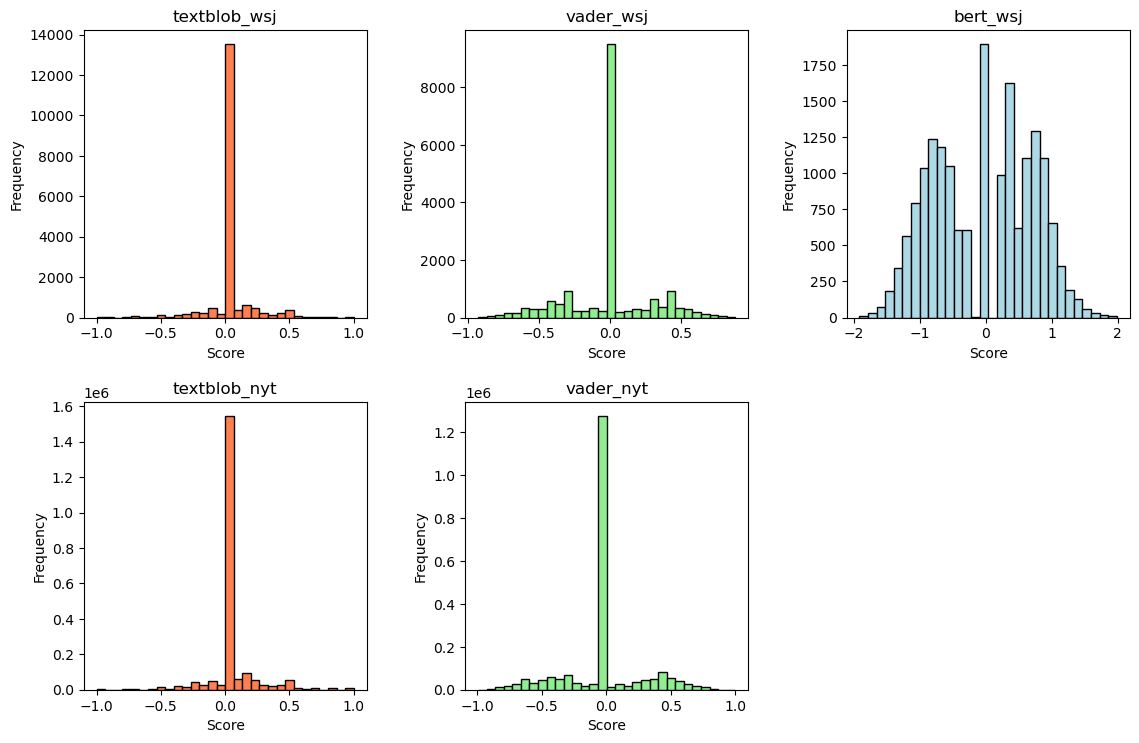

In [49]:
# Plot specs
n_plots = len(sentiment_cols)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

# Plot
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 4))
fig.tight_layout(pad=4.0)
axes = axes.flatten()
colors = ["coral", "lightgreen", "lightblue"]

for i, col in enumerate(sentiment_cols):
    ax = axes[i]
    if col in df_nyt.columns:
        data = df_nyt[col]
    elif col in df_wsj.columns:
        data = df_wsj[col]
    ax.hist(data, bins=30, edgecolor='k', color=colors[i%n_cols])
    ax.set_title(sentiment_cols[i])
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')

fig.delaxes(axes[5])
plt.show()

TODO: Write a brief description about these graphs -- distributions look interesting? how do they compare

In [50]:
def get_word_cloud(df, source):
    text = " ".join(headline for headline in df['headline'])
    filtered_text = " ".join(word.lower() for word in text.split() if len(word) > 1 and word.isalpha())

    word_cloud = WordCloud(
        background_color="white",
        max_words=1000,
        width=800,
        height=400,
        collocations=False 
    ).generate(filtered_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Word Cloud of {source} Headlines (Filtered > 1 letter word)")
    plt.show()

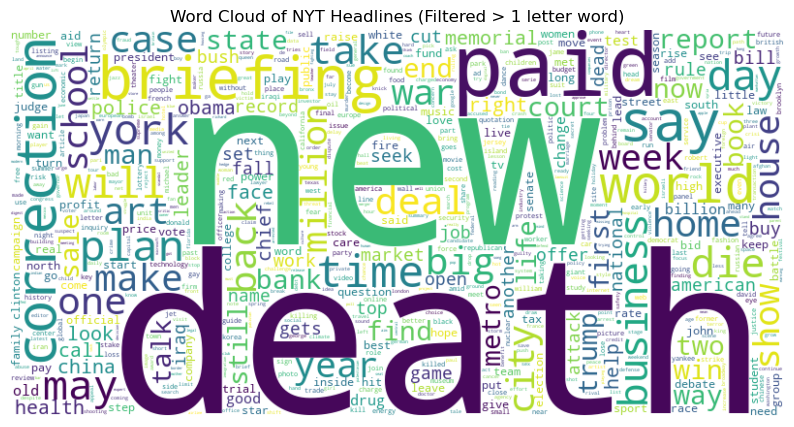

In [51]:
get_word_cloud(df_nyt, "NYT")

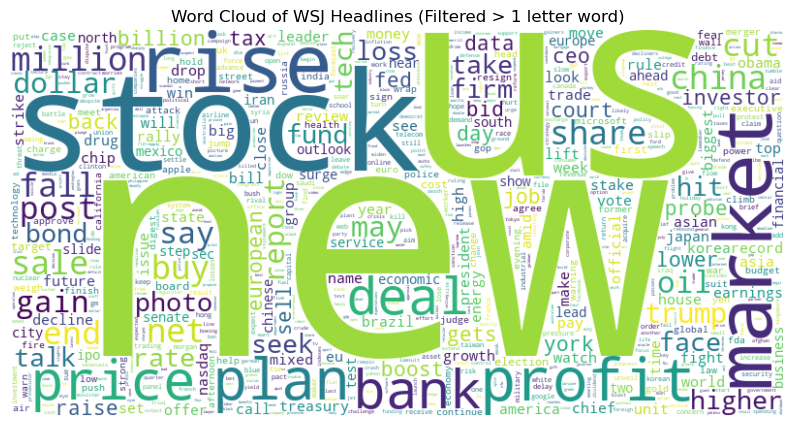

In [52]:
get_word_cloud(df_wsj, "WSJ")

TODO: Write a brief caption about the word clouds. The top one is the NYT headlines and the bottom one is the WSJ headlines.

### **Aggregating Monthly Sentiment Scores**

We now aggregate the sentiment scores from the NYT and WSJ datasets on a monthly basis. A new column `year_month` is created in each dataset to represent the year and month of each headline. The sentiment scores for each month are calculated by excluding neutral sentiment scores (i.e. scores of 0) and averaging the sentiment for each month. This ensures the monthly averages reflect only meaningful (positive or negative) sentiments.

The aggregated monthly sentiment scores from the NYT and WSJ datasets are then combined into a single data frame, aligning the data on the `year_month` column.

In [53]:
# Create a month column
df_nyt['date'] = pd.to_datetime(df_nyt['date']).dt.tz_localize(None)
df_wsj['date'] = pd.to_datetime(df_wsj['date']).dt.tz_localize(None)
df_nyt['year_month'] = df_nyt['date'].dt.to_period('M')
df_wsj['year_month'] = df_wsj['date'].dt.to_period('M')

# Aggregate sentiment scores removing neutral (0) scores
def mean_ignore_zero(series):
    return series[series != 0].mean()

nyt_monthly_avg = df_nyt.groupby('year_month')[nyt_sentiment_cols].agg(mean_ignore_zero)
wsj_monthly_avg = df_wsj.groupby('year_month')[wsj_sentiment_cols].agg(mean_ignore_zero)

In [54]:
# Combine NYT and WSJ data
monthly_avg = pd.concat([nyt_monthly_avg, wsj_monthly_avg], axis=1)
monthly_avg = monthly_avg.reset_index()
display(monthly_avg.head())

,year_month,textblob_nyt,vader_nyt,textblob_wsj,vader_wsj,bert_wsj
0,1998-07,0.098459,-0.020807,0.119375,0.042477,-0.047076
1,1998-08,0.100825,-0.020114,0.078856,0.053012,-0.058711
2,1998-09,0.101843,-0.008985,0.100000,0.068224,-0.003143
3,1998-10,0.098454,-0.000390,0.143914,0.108588,0.132225
4,1998-11,0.086301,0.007860,-0.171111,-0.079321,-0.053441


#### **Scaling Sentiment Scores**

To ensure that our scores are of similar magnitude, we will scale our sentiment scores between -1 and 1.

In [55]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(monthly_avg[sentiment_cols])
monthly_avg[sentiment_cols] = scaled_values

display(monthly_avg.head())

,year_month,textblob_nyt,vader_nyt,textblob_wsj,vader_wsj,bert_wsj
0,1998-07,-0.194118,0.221210,0.189212,0.179135,-0.003294
1,1998-08,-0.144381,0.229742,0.023334,0.221660,-0.034428
2,1998-09,-0.122974,0.366776,0.109894,0.283067,0.114269
3,1998-10,-0.194217,0.472602,0.289672,0.445999,0.476502
4,1998-11,-0.449710,0.574187,-1.000000,-0.312517,-0.020326


_______________

## **S&P500 Data**

Now that wehave thoroughly explored the NYT and WSJ headline data supplemented with sentiment scores, let's take a look at the S&P500 data. This data is part of Python’s built-in Yahoo Finance function (yfinance).

In [56]:
# Match start and end date of NYT and WSJ headlines
start_date = monthly_avg['year_month'].dt.start_time.min().strftime('%Y-%m-%d')
end_date = monthly_avg['year_month'].dt.end_time.max().strftime('%Y-%m-%d')

In [57]:
# Fetch S&P 500 data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(start=start_date, end=end_date, interval="1mo")

monthly_closing_prices = sp500_data[['Close']].copy()
monthly_closing_prices.reset_index(inplace=True)
monthly_closing_prices['Date'] = monthly_closing_prices['Date'].dt.strftime('%Y-%m')
monthly_closing_prices['Date'] = pd.to_datetime(monthly_closing_prices['Date'])

In [58]:
# Display the data
print("Monthly Closing Prices of S&P 500:")
display(monthly_closing_prices.head(5))

Monthly Closing Prices of S&P 500:


,Date,Close
0,1998-07-01,1120.670044
1,1998-08-01,957.280029
2,1998-09-01,1017.010010
3,1998-10-01,1098.670044
4,1998-11-01,1163.630005


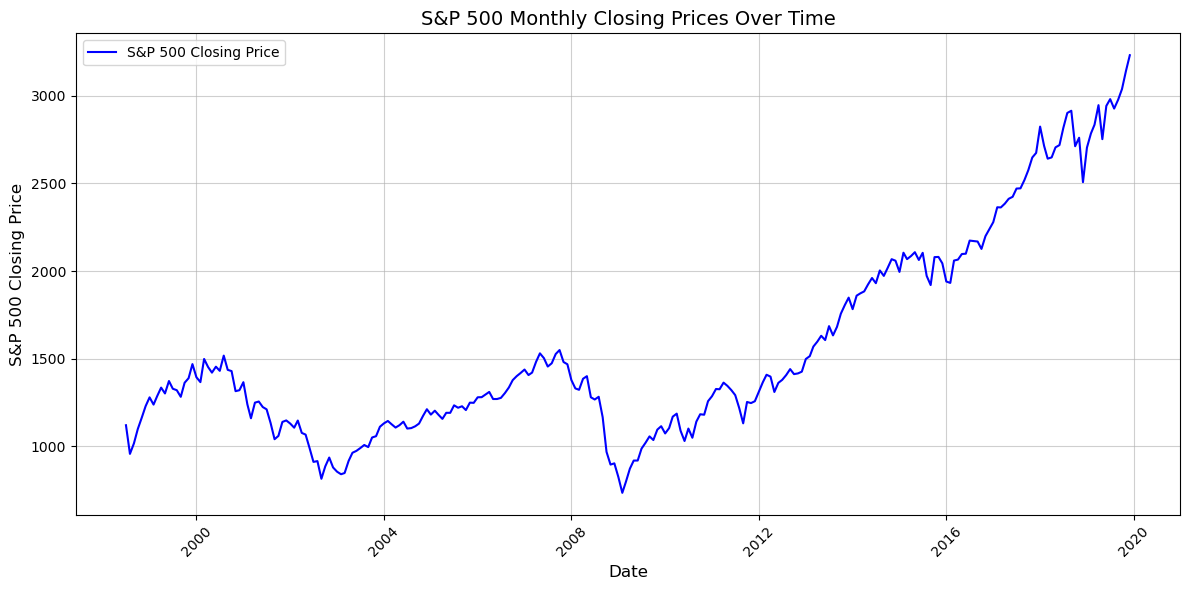

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_closing_prices['Date'], monthly_closing_prices['Close'], label='S&P 500 Closing Price', color='blue')
plt.xlabel('Date', fontsize=12)
plt.ylabel('S&P 500 Closing Price', fontsize=12)
plt.title('S&P 500 Monthly Closing Prices Over Time', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TODO: insert graph explanation/caption

_______

## **Combine Headlines and S&P500 Data**

Now that the S&P500 data hasbeen cleaned and aggregated by month, we will then combine the aggregated monthly sentiment scores from the NYT and WSJ datasets with the closing prices, aligning the data on the `year_month` column.

In [60]:
monthly_closing_prices.sort_values('Date', inplace=True)
monthly_closing_prices['Change'] = monthly_closing_prices['Close'].diff()

# Add a column to indicate increase (1) or decrease (-1)
monthly_closing_prices['SP500_Trend'] = monthly_closing_prices['Change'].apply(lambda x: 1 if x > 0 else -1)
scaler = MinMaxScaler(feature_range=(-1, 1))
monthly_closing_prices['scaled_close'] = scaler.fit_transform(monthly_closing_prices[['Close']])

if isinstance(monthly_avg['year_month'].iloc[0], pd.Period):
    monthly_avg['year_month'] = monthly_avg['year_month'].dt.to_timestamp()

if 'SP500_Trend' not in monthly_avg.columns or 'scaled_close' not in monthly_avg.columns:
    monthly_avg = pd.merge(monthly_avg, monthly_closing_prices[['Date', 'SP500_Trend', 'scaled_close']], 
                           left_on='year_month', right_on='Date', how='left')
    monthly_avg.drop(columns=['Date'], inplace=True)
else:
    print("SP500_Trend and scaled_close columns already exist. Skipping merge.")

#### **Final Dataset**

Let's take a peak at the newly combined dataframe! It should have the year-month, the TextBlob, VADER, and BERT (WSJ only) sentiment scores for NYT and WSJ headlines, as well as the SP500 trend (increase/decrease) and scaled closing price.

In [61]:
display(monthly_avg.head())

,year_month,textblob_nyt,vader_nyt,textblob_wsj,vader_wsj,bert_wsj,SP500_Trend,scaled_close
0,1998-07-01,-0.194118,0.221210,0.189212,0.179135,-0.003294,-1,-0.691003
1,1998-08-01,-0.144381,0.229742,0.023334,0.221660,-0.034428,-1,-0.821941
2,1998-09-01,-0.122974,0.366776,0.109894,0.283067,0.114269,1,-0.774075
3,1998-10-01,-0.194217,0.472602,0.289672,0.445999,0.476502,1,-0.708634
4,1998-11-01,-0.449710,0.574187,-1.000000,-0.312517,-0.020326,1,-0.656576


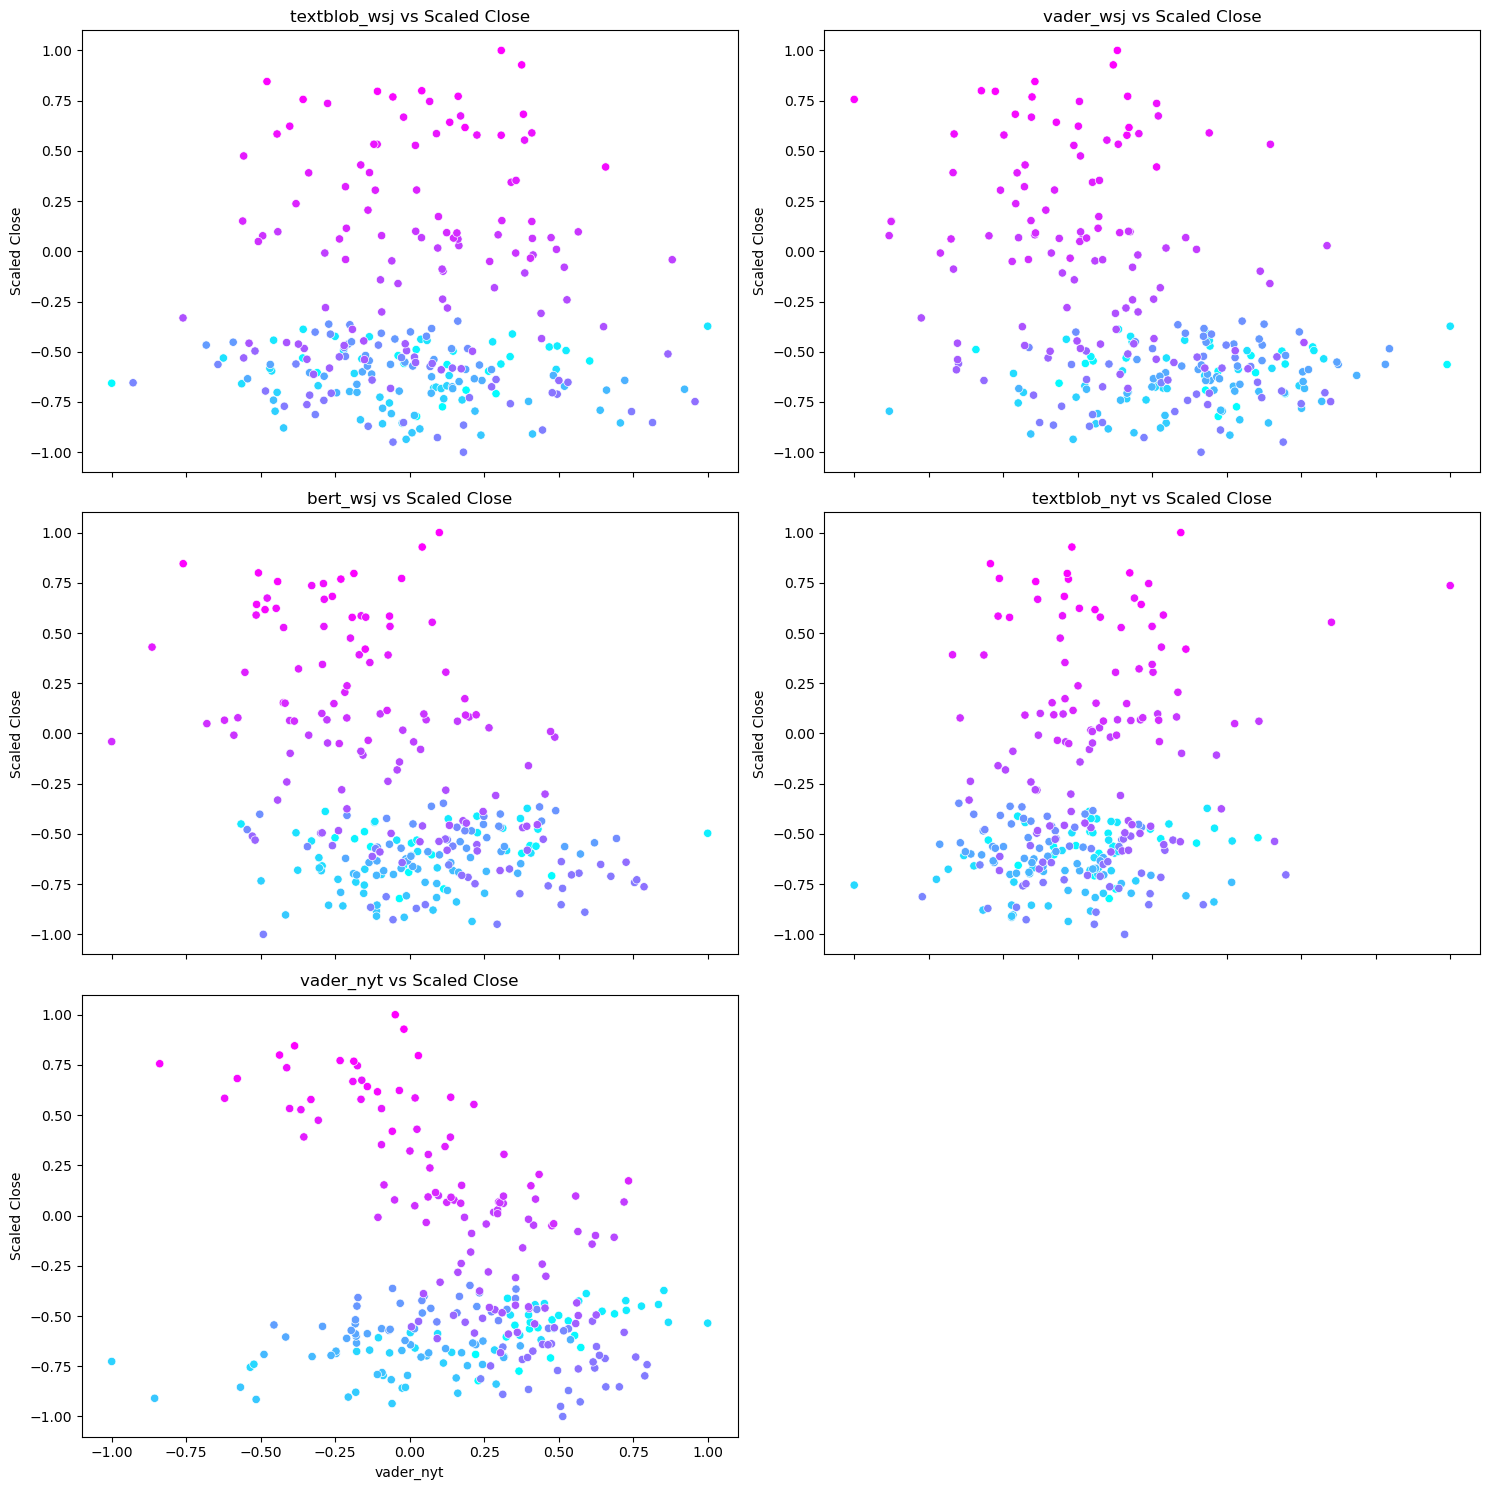

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, col in enumerate(sentiment_cols):
    sns.scatterplot(
        ax=axes[i],
        data=monthly_avg,
        x=col,
        y='scaled_close',
        hue='year_month',
        palette='cool',
        legend=False
    )
    axes[i].set_title(f'{col} vs Scaled Close')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Scaled Close')

axes[5].axis('off')
plt.tight_layout()
plt.show()

TODO: Wrtie a brief description on the different sentiment scores for the different journals plotted against the scaled closing price. Are there trends? maybe a little for vader nyt?

#### **Test and Train Sets**

Great! Now that we have our final dataset, we can split it into our train and test set. Since we are dealing with time series data, we will save the last 2 years of data for our test set.

In [63]:
# Define the test cutoff date for the last 2 years
monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'])
cutoff_date = monthly_avg['year_month'].max() - pd.DateOffset(years=2)

# Split
train = monthly_avg[monthly_avg['year_month'] <= cutoff_date]
test = monthly_avg[monthly_avg['year_month'] > cutoff_date]

X = ['textblob_nyt', 'vader_nyt', 'textblob_wsj', 'vader_wsj', 'bert_wsj']
y = ['SP500_Trend', 'scaled_close']
x_train, y_train = train[X], train[y]
x_test, y_test = test[X], test[y]

In [64]:
# Shapes of the splits
print("(num_obs, num_cols)")
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

(num_obs, num_cols)
x_train shape: (234, 5), y_train shape: (234, 2)
x_test shape: (24, 5), y_test shape: (24, 2)


<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Baseline Model**

For our baseline model, we will use majority class for the classification task.

In [65]:
y_train_trend = y_train['SP500_Trend']
y_test_trend = y_test['SP500_Trend']

# Determine the majority class
majority_class = y_train_trend.mode()[0]

y_train_majority_pred = [majority_class] * len(y_train_trend)
y_test_majority_pred = [majority_class] * len(y_test_trend)

maj_train_accuracy = accuracy_score(y_train_trend, y_train_majority_pred)
maj_test_accuracy = accuracy_score(y_test_trend, y_test_majority_pred)

In [66]:
print(f"Majority Class: {majority_class}")
print(f"Train Accuracy: {maj_train_accuracy:.2f}")
print(f"Test Accuracy: {maj_test_accuracy:.2f}")

Majority Class: 1
Train Accuracy: 0.61
Test Accuracy: 0.75


#### **Rebalancing the Dataset**

Given the train accuracy of the majority class model, there is a data imbalance.

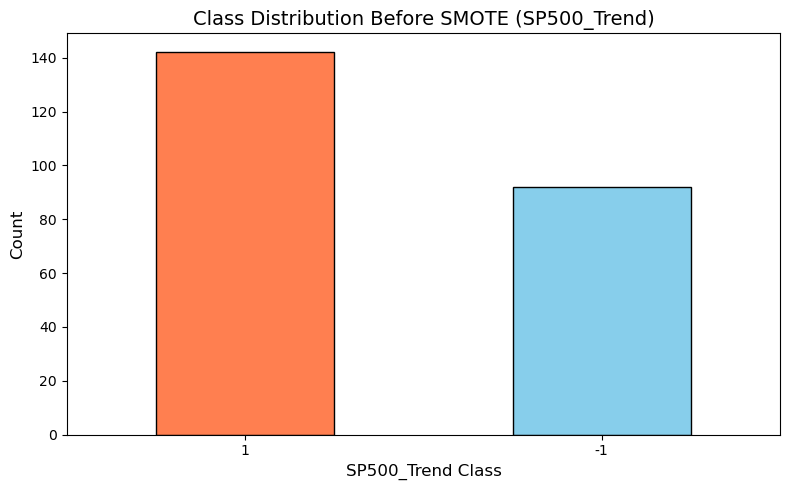

In [67]:
plt.figure(figsize=(8, 5))
y_train['SP500_Trend'].value_counts().plot(kind='bar', color=['coral', 'skyblue'], edgecolor='black')
plt.title('Class Distribution Before SMOTE (SP500_Trend)', fontsize=14)
plt.xlabel('SP500_Trend Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Since there is an imbalance in class distributions, we will use SMOTE to generate a more balanced dataset.

In [68]:
smote = SMOTE(random_state=42)
x_train_balanced, y_train_trend_balanced = smote.fit_resample(x_train, y_train_trend)

n_synthetic_samples = len(y_train_trend_balanced) - len(y_train_trend)
synthetic_scaled_close = np.random.choice(y_train['scaled_close'], size=n_synthetic_samples, replace=True)
y_train_scaled_close_balanced = np.concatenate([y_train['scaled_close'].values, synthetic_scaled_close])
y_train_balanced = pd.DataFrame({
    'SP500_Trend': y_train_trend_balanced,
    'scaled_close': y_train_scaled_close_balanced
})

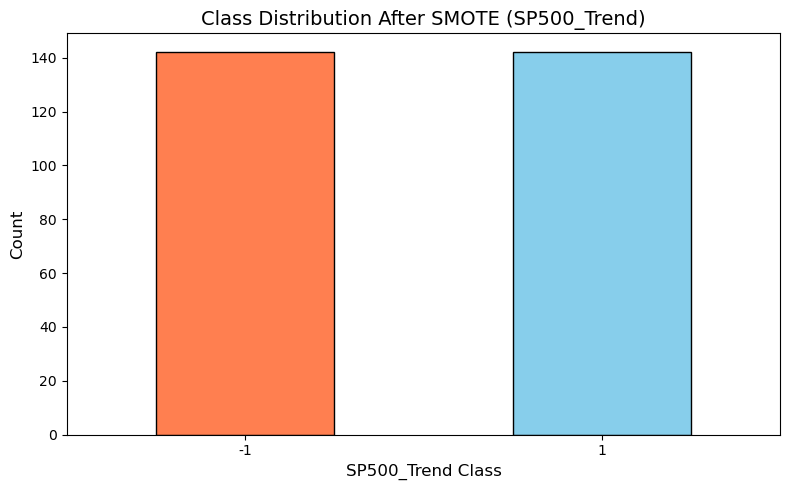

In [69]:
plt.figure(figsize=(8, 5))
y_train_balanced['SP500_Trend'].value_counts().plot(kind='bar', color=['coral', 'skyblue'], edgecolor='black')
plt.title('Class Distribution After SMOTE (SP500_Trend)', fontsize=14)
plt.xlabel('SP500_Trend Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Now the dataset is balanced!

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Final Models**

We will use Random Forests and Boosting methods as our final models to analyze the relationship between sentiment scores of NYT and WSJ headlines and the subsequent S&P 500 closing prices.

TODO: Insert flow chart + add a description explaining the flow chart

### **Random Forest Model**

In [70]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [71]:
# Tuning parameters for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit model
y_train_trend, y_test_trend = y_train['SP500_Trend'], y_test['SP500_Trend']
grid_search.fit(x_train, y_train_trend)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [72]:
# Print best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [73]:
# Evaluate performance
best_rf_model = grid_search.best_estimator_
y_train_pred = best_rf_model.predict(x_train)
y_test_pred = best_rf_model.predict(x_test)

print("Test Performance:")
print(classification_report(y_test_trend, y_test_pred))

rf_train_accuracy = accuracy_score(y_train_trend, y_train_pred)
rf_test_accuracy = accuracy_score(y_test_trend, y_test_pred)
print("Train Accuracy:", rf_train_accuracy)
print("Test Accuracy:", rf_test_accuracy)

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test_trend, y_test_pred))

Test Performance:
              precision    recall  f1-score   support

          -1       0.25      0.33      0.29         6
           1       0.75      0.67      0.71        18

    accuracy                           0.58        24
   macro avg       0.50      0.50      0.50        24
weighted avg       0.62      0.58      0.60        24

Train Accuracy: 0.9102564102564102
Test Accuracy: 0.5833333333333334

Confusion Matrix (Test Set):
[[ 2  4]
 [ 6 12]]


### **AdaBoost Model**

In [74]:
# Tuning parameters for AdaBoost
param_grid = {
    'n_estimators': [50, 75, 100, 125],  
    'learning_rate': [0.1, 0.2, 1.0],
    'estimator': [
        DecisionTreeClassifier(max_depth=1, random_state=42, class_weight='balanced'),
        DecisionTreeClassifier(max_depth=2, random_state=42, class_weight='balanced')
    ]
}

adaboost_model = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(estimator=adaboost_model, param_grid=param_grid, 
                           cv=3, scoring='accuracy', n_jobs=2, verbose=1)
grid_search.fit(x_train, y_train_trend)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=2,
             param_grid={'estimator': [DecisionTreeClassifier(class_weight='balanced',
                                                              max_depth=1,
                                                              random_state=42),
                                       DecisionTreeClassifier(class_weight='balanced',
                                                              max_depth=2,
                                                              random_state=42)],
                         'learning_rate': [0.1, 0.2, 1.0],
                         'n_estimators': [50, 75, 100, 125]},
             scoring='accuracy', verbose=1)

In [75]:
# Print best parameters
best_adaboost_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42), 'learning_rate': 0.2, 'n_estimators': 100}


In [76]:
# Evaluate
y_train_pred = best_adaboost_model.predict(x_train)
y_test_pred = best_adaboost_model.predict(x_test)

print("\nTest Performance:")
print(classification_report(y_test_trend, y_test_pred))

ada_train_accuracy = accuracy_score(y_train_trend, y_train_pred)
ada_test_accuracy = accuracy_score(y_test_trend, y_test_pred)
print("Test Accuracy:", accuracy_score(y_test_trend, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test_trend, y_test_pred))

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test_trend, y_test_pred))


Test Performance:
              precision    recall  f1-score   support

          -1       0.42      0.83      0.56         6
           1       0.92      0.61      0.73        18

    accuracy                           0.67        24
   macro avg       0.67      0.72      0.64        24
weighted avg       0.79      0.67      0.69        24

Test Accuracy: 0.6666666666666666
Test Accuracy: 0.6666666666666666

Confusion Matrix (Test Set):
[[ 5  1]
 [ 7 11]]


In [79]:
accuracies = {
    "Model": ["Majority Class", "Random Forest", "AdaBoost"],
    "Train Accuracy": [maj_train_accuracy, rf_train_accuracy, ada_train_accuracy],
    "Test Accuracy": [maj_test_accuracy, rf_test_accuracy, ada_test_accuracy],
}

display(pd.DataFrame(accuracies))

,Model,Train Accuracy,Test Accuracy
0,Majority Class,0.606838,0.750000
1,Random Forest,0.910256,0.583333
2,AdaBoost,1.000000,0.666667


### **Investment Simulation**

To further test the performance of our models, we simulate investment strategies with the S&P500 using the predictions of Random Forest, AdaBoosting, and Majority Class models.

TODO: rethink the policy for investing/not investing and edit the code blocks below to match that

TODO: Add description here on what this policy is/how the simulation works

In [80]:
def simulate_investment(model_predictions, actual_changes, init_investment):
    portfolio = init_investment
    portfolio_history = [portfolio]
    
    for prediction, actual_change in zip(model_predictions, actual_changes):
        # TODO: EDIT POLICY!
        if prediction == 1: 
            portfolio *= (1 + actual_change)
        portfolio_history.append(portfolio)
    
    return portfolio_history

In [81]:
# Simulate portfolios
rf_predictions = best_rf_model.predict(x_test)
boosting_predictions = best_adaboost_model.predict(x_test)
majority_class_predictions = [y_train_trend.mode()[0]] * len(y_test)

actual_changes = (y_test['scaled_close'].values[1:] - y_test['scaled_close'].values[:-1]) / y_test['scaled_close'].values[:-1]
init_investment = 1000

rf_portfolio = simulate_investment(rf_predictions, actual_changes, init_investment)
boosting_portfolio = simulate_investment(boosting_predictions, actual_changes, init_investment)
majority_portfolio = simulate_investment(majority_class_predictions, actual_changes, init_investment)

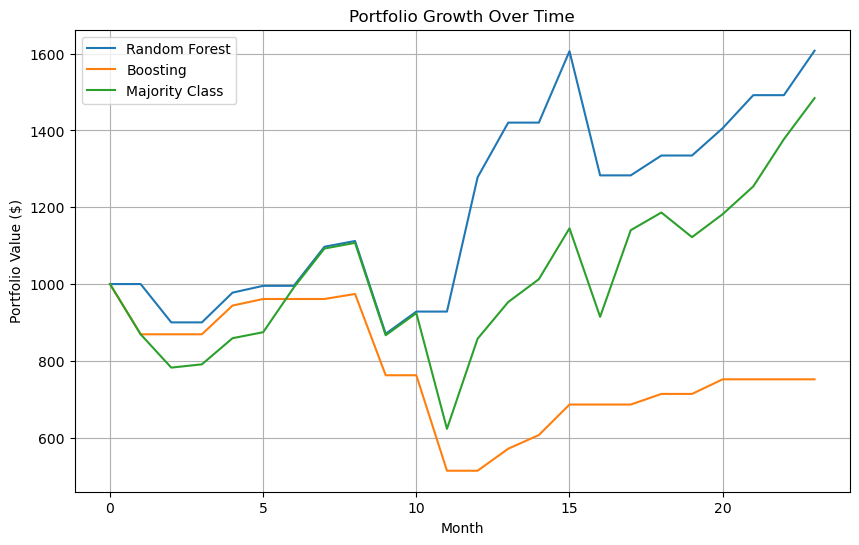

In [82]:
# Plot simulation results
simulation_results = pd.DataFrame({
    'Month': np.arange(len(rf_portfolio)),
    'Random Forest': rf_portfolio,
    'Boosting': boosting_portfolio,
    'Majority Class': majority_portfolio
})

plt.figure(figsize=(10, 6))
plt.plot(simulation_results['Month'], simulation_results['Random Forest'], label='Random Forest')
plt.plot(simulation_results['Month'], simulation_results['Boosting'], label='Boosting')
plt.plot(simulation_results['Month'], simulation_results['Majority Class'], label='Majority Class')
plt.title('Portfolio Growth Over Time')
plt.xlabel('Month')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
print("Final Portfolio Values:")
print(simulation_results.iloc[-1])

Final Portfolio Values:
Month               23.000000
Random Forest     1607.422179
Boosting           751.992200
Majority Class    1483.983893
Name: 23, dtype: float64


### **Feature Importance**

TODO: graph feature importance for Random Forest and AdaBoost

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Model Interpretation and Results**

TODO: last thing to do once everything is run/finalized models and results

Results: drawing reasonable conclusions & speculations, addressing strengths, limitations, and future works

Thanks for reading! :)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>